In [3]:
!pip install Pillow
!pip install -U image
!pip install wheel

!pip install torch torchvision

  Using cached image-1.5.33.tar.gz (15 kB)
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.3/8.3 MB 83.0 MB/s eta 0:00:00
  Created wheel for image: filename=image-1.5.33-py2.py3-none-any.whl size=19482 sha256=78cfaf1140e9f683ba8ccba68b8a2786f76bf08a15c2b2ab969021364777dcb1
  Stored in directory: /root/.cache/pip/wheels/70/0c/a4/7cfa53a5c6225c2db2bfec08e782b43d0f25fdae2e995b69be
Successfully built image


In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from torch.utils.data import random_split

import torchvision.transforms as transforms
from torchvision import datasets

from matplotlib.colors import LinearSegmentedColormap

import numpy as np

import sys

import os

import math

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print("Using device:", device)

Using device: cuda:0


In [3]:
transform = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])

train_data = datasets.MNIST(root = './data', train = True, download = True, transform = transform)
test_data = datasets.MNIST(root = './data', train = False, download = True, transform = transform)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9.91M/9.91M [00:00<00:00, 11.0MB/s]


Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28.9k/28.9k [00:00<00:00, 47.6MB/s]

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw



Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1.65M/1.65M [00:00<00:00, 1.67MB/s]


Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4.54k/4.54k [00:00<00:00, 11.7MB/s]

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw



In [4]:
batch_size = 64
train_loader = DataLoader(train_data, batch_size = batch_size, shuffle = True, num_workers = 2, pin_memory = True)
test_loader = DataLoader(test_data, batch_size = batch_size, shuffle = False, num_workers = 2, pin_memory = True)

In [5]:
class CNNModel(nn.Module):
  def __init__(self):
    super(CNNModel, self).__init__()
    self.conv1 = nn.Conv2d(1, 32, kernel_size = 3)
    self.conv2 = nn.Conv2d(32, 64, kernel_size = 3)
    self.pool = nn.MaxPool2d(2)
    self.fc1 = nn.Linear(64 * 5 * 5, 128)
    self.fc2 = nn.Linear(128, 10)

  def forward(self, x):
    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = x.view(-1, 64 * 5 * 5)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)
    return x

In [6]:
model = CNNModel().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr = 0.001)

model_path = '/content/mnist_cnn_model.pth'
if os.path.exists(model_path):
  print("Loading saved model...")
  model.load_state_dict(torch.load(model_path, weights_only = True))
  model.eval()
else:
  print("Model not found. Training a new model...")

  epochs = 5
  early_stopping_patience = 3
  best_val_loss = float('inf')
  patience_counter = 0

  for epoch in range(epochs):
    model.train()
    running_loss = 0.0
    for inputs, labels in train_loader:
      inputs, labels = inputs.to(device), labels.to(device)

      optimizer.zero_grad()

      outputs = model(inputs)
      loss = criterion(outputs, labels)

      loss.backward()
      optimizer.step()

      running_loss += loss.item()

    model.eval()
    val_loss = 0.0
    with torch.no_grad():
      for inputs, labels in test_loader:
        inputs, labels = inputs.to(device), labels.to(device)
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        val_loss += loss.item()

    val_loss /= len(test_loader)
    print(f'Epoch {epoch + 1}, Training Loss: {running_loss / len(train_loader): .4f}, Validation Loss: {val_loss: .4f}')

    if val_loss < best_val_loss:
      best_val_loss = val_loss
      patience_counter = 0
      torch.save(model.state_dict(), model_path)
    else:
      patience_counter += 1

    if patience_counter >= early_stopping_patience:
      print("Early stopping triggered")
      break

  print("Model trained and saved.")

Loading saved model...


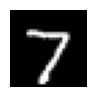

Predicted class is 7


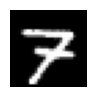

Predicted class is 7


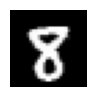

Predicted class is 8


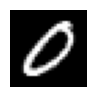

Predicted class is 0


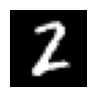

Predicted class is 2


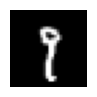

Predicted class is 8


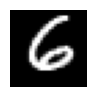

Predicted class is 6


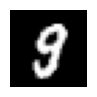

Predicted class is 9


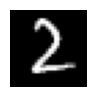

Predicted class is 2


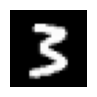

Predicted class is 3


In [7]:
import matplotlib.pyplot as plt

def tensor2image(tensor):
  image = tensor.squeeze().cpu().numpy()
  return image

count = 0
for inputs, labels in test_loader:
  if count >= 10: break
  inputs, labels = inputs.to(device), labels.to(device)

  plt.figure(figsize=(1,1))
  plt.imshow(tensor2image(inputs[0]), cmap='gray')
  plt.axis('off')
  plt.show()

  with torch.no_grad():
    output = model(inputs)
    prediction = output.argmax(-1)

  print('Predicted class is', prediction[0].item())
  count += 1

In [8]:
def occlude_image(image, xy_start, xy_size, box_val = -1, box_shape="circle"):
  """
  Occlude part of the MNIST image by setting a region to black (value 0) or applying a circle.

  Parameters:
  - image (Tensor): The image tensor (expected shape: [1, height, width]).
  - xy_start (tuple): The (x, y) coordinates of the top-left corner of the occlusion region.
  - xy_size (tuple): The size (height, width) of the occlusion box or circle.
  - box_val (int or float): The value to set for the occlusion. Default is -1 (black).
  - box_shape (str): The shape of the occlusion, either "square" or "circle". Default is "square".

  Returns:
  - Tensor: The occluded image.
  """

  if len(image.shape) != 3 or image.shape[0] != 1:
    raise ValueError("Input image must have shape [1, height, width].")

  _, height, width = image.shape

  x_start, y_start = xy_start
  w_size, h_size = xy_size
  x_end, y_end = xy_start[0] + xy_size[0], xy_start[1] + xy_size[1]

  if x_start < 0 or y_start < 0:
    raise ValueError("Top-left corner of the occlusion box cannot have negative coordinates.")

  if x_end > width or y_end > height:
    raise ValueError("The occlusion box exceeds the image dimensions.")

  occluded_image = image.clone()

  if box_shape == "square":
    # Apply a square occlusion (already done by the rectangular region logic)
    occluded_image[0, y_start : y_start + h_size, x_start : x_start + w_size] = box_val
  elif box_shape == "circle":
    # Apply a circular occlusion
    radius = min(w_size, h_size) // 2  # Make the circle fit within the square area
    center_x, center_y = x_start + w_size // 2, y_start + h_size // 2

    # Loop through the square area and apply a circle mask
    for y in range(y_start, y_end):
      for x in range(x_start, x_end):
        # Check if the point (x, y) is inside the circle
        if (x - center_x)**2 + (y - center_y)**2 <= radius**2:
          occluded_image[0, y, x] = box_val

  return occluded_image

In [9]:
def conv_occlude(image, kernel_width, kernel_step):
  """
  Occludes the image in many different spots (sliding occlusion like a kernel along the image)

  Parameters:
  - image (Tensor): The image tensor (expected shape: [1, height, width]).
  - kernel_width (int): kernel is square, so is shape (kernel_width, kernel_width)
  - kernel_step (int): step taking as if this were a kernel

  Returns:
  - Tensor: 3D with confidence values for each class given the occlusions
  """
  if len(image.shape) != 3 or image.shape[0] != 1: raise ValueError("Input image must have shape [1, height, width].")

  _, height, width = image.shape

  confidence_width = (width - kernel_width) // kernel_step + 1
  confidence_map = torch.zeros((confidence_width, confidence_width, 10))

  for y in range(confidence_width):
    for x in range(confidence_width):
      occluded_image = occlude_image(image, (x, y), (kernel_width, kernel_width))
      occluded_image = occluded_image.to(device)
      model.eval()
      with torch.no_grad():
        output = model(occluded_image)
        output = torch.nn.functional.softmax(output, dim = 1)
        confidence_map[y, x, :] = output.cpu()

  return confidence_map

In [10]:
def scalable_convs(image, kernel_widths, kernel_step):
  """
  Calculates many sizes of convultions

  Paramters:
  - image (Tensor): The image tensor (expected shape: [1, height, width]).
  - kernel_widths (list of ints): all kernel widths
  - kernel_step (int): step taking as if this were a kernel

  Returns:
  - Dictionary of 3D Tensors: key being kernel_width and value being the 3D tensor given by conv_occlude(...)
  """

  if len(image.shape) != 3 or image.shape[0] != 1: raise ValueError("Input image must have shape [1, height, width].")

  tensor_dict = {}

  for k_width in kernel_widths:
    tensor_dict[k_width] = conv_occlude(image, k_width, kernel_step)

  return tensor_dict

In [11]:
def occlude_region(result_tensor, y, x, k_size, box_val, box_shape="square"):
    """
    Apply either a square or circular occlusion on the given region.

    Parameters:
    - result_tensor (Tensor): The image tensor to apply occlusion on.
    - y, x (int): Top-left corner of the occlusion.
    - k_size (int): Size of the occlusion.
    - box_val (int or float): The value to set for the occlusion.
    - box_shape (str): The shape of the occlusion, either "square" or "circle".

    Returns:
    - Tensor: The updated result_tensor with the occlusion applied.
    """
    radius = k_size // 2  # For circular occlusion, calculate the radius

    center_x, center_y = x + k_size // 2, y + k_size // 2  # Get the center of the square region

    for i in range(y, y + k_size):
        for j in range(x, x + k_size):
            if box_shape == "square":
                # Apply square occlusion (fill the square region with box_val)
                result_tensor[0, i, j] = torch.maximum(result_tensor[0, i, j], torch.tensor(box_val))
            elif box_shape == "circle":
                # Apply circular occlusion (only within the circle)
                if (i - center_y)**2 + (j - center_x)**2 <= radius**2:
                    result_tensor[0, i, j] = torch.maximum(result_tensor[0, i, j], torch.tensor(box_val))

    return result_tensor



def illustrate_prep(importance, class_confs, box_shape="circle"):
    """
    Prepare the images for illustration by applying occlusion based on importance.
    """
    def illustrate_prep_helper(class_conf):
        num_for_significant = 2
        indices_by_ksize = {}

        result_tensor = torch.zeros_like(image)

        best_signif_for_k_size = None
        for k_size in importance.keys():
            sized_kernel = importance[k_size]
            class_kernel = sized_kernel[:, :, class_conf]

            topk_values, topk_indices = torch.topk(class_kernel.flatten(), class_kernel.numel() // 4)
            topk_indices_2d = [divmod(idx.item(), sized_kernel.shape[1]) for idx in topk_indices]

            best_signif_for_k_size = topk_values[0] if best_signif_for_k_size is None else max(topk_values[0], best_signif_for_k_size)

            valid_indices_2d = []

            for i in range(len(topk_values)):
                if topk_values[0] / topk_values[i] < num_for_significant:
                    valid_indices_2d.append(topk_indices_2d[i])
                else: break

            indices_by_ksize[k_size] = valid_indices_2d

        similarity_threshold = 0.3
        for k_size in importance.keys():
            max_for_k = importance[k_size][:, :, class_conf].max()
            if best_signif_for_k_size / max_for_k > num_for_significant: continue
            for (y, x) in indices_by_ksize[k_size]:
                region = result_tensor[0, y : y + k_size, x : x + k_size]
                current_max_value = region.max().item()
                new_value = importance[k_size][y, x, class_conf].item()
                if abs(current_max_value - new_value) < similarity_threshold: continue

                # Apply occlusion (square or circle)
                result_tensor = occlude_region(result_tensor, y, x, k_size, new_value, box_shape)

        image_np = image.squeeze(0).cpu().numpy() if isinstance(image, torch.Tensor) else image
        result_tensor_np = result_tensor.squeeze(0).cpu().numpy() if isinstance(result_tensor, torch.Tensor) else result_tensor
        return image_np, result_tensor_np

    all_image_np, all_result_tensor_np = [], []
    for class_conf in class_confs:
        image_np, result_tensor_np = illustrate_prep_helper(class_conf)
        all_image_np.append(image_np)
        all_result_tensor_np.append(result_tensor_np)

    return all_image_np, all_result_tensor_np

In [12]:
colors = [(0, 0, 0, 0),
          (1, 0.647, 0, 1),
          (1, 0, 0, 1)]
n_bins = 100
cmap_name = "transparent_to_orange_to_red"
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

def illustrate(all_img1, all_img2, class_conf, label):
    num_images = len(all_img1)

    num_columns = math.ceil(math.sqrt(num_images))
    num_rows = math.ceil(num_images / num_columns)
    fig, axes = plt.subplots(num_rows, num_columns, figsize=(13, 7))
    axes = axes.flatten()
    im1_list = []
    im2_list = []

    for i in range(num_images):
        if(class_conf[i]) == '': continue
        img1 = all_img1[i]
        img2 = all_img2[i]

        ax = axes[i]
        im1 = ax.imshow(img1, cmap='gray')
        im1_list.append(im1)

        # Use the custom colormap for img2
        im2 = ax.imshow(img2, cmap=cm, alpha=0.5, vmin=0, vmax=1)  # Apply alpha transparency to overlay
        im2_list.append(im2)

        ax.axis('off')
        ax.set_title(f"x = {class_conf[i]}")

    # Hide any empty subplots
    for i in range(num_images, len(axes)):
        axes[i].axis('off')

    # Create the colorbars
    cbar1 = fig.colorbar(im1_list[0], ax=axes.ravel().tolist(), shrink=0.95)
    cbar1.set_label('Grayscale Intensity')

    # Colorbar for the custom cmap (transparent to orange to red)
    cbar2 = fig.colorbar(im2_list[0], ax=axes.ravel().tolist(), shrink=0.95)
    cbar2.set_label('Overlay Intensity')

    plt.suptitle(f'What differentiates digit {label} from x?', fontsize = 24, fontweight = 'bold')
    plt.show()

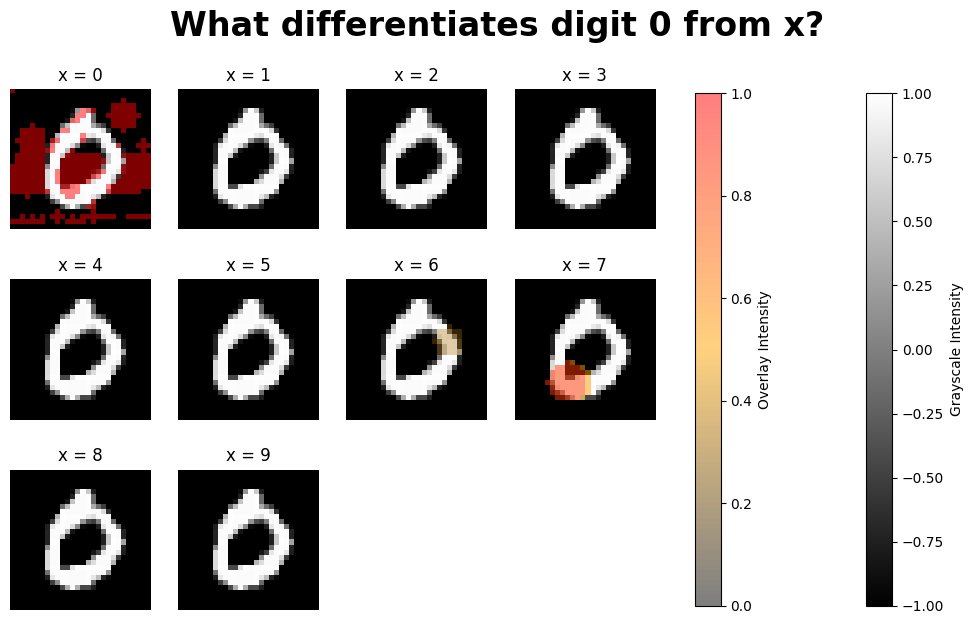

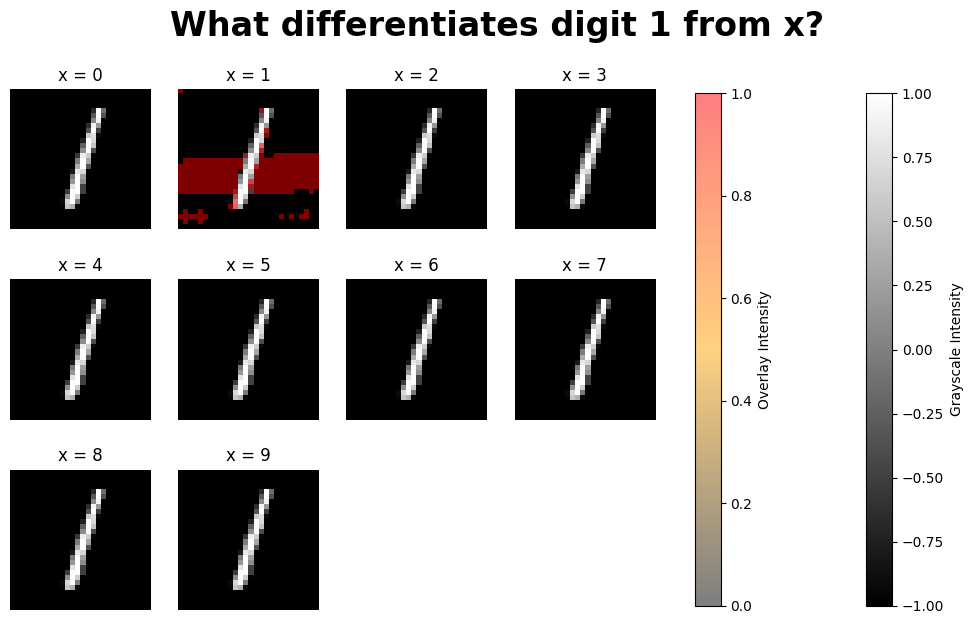

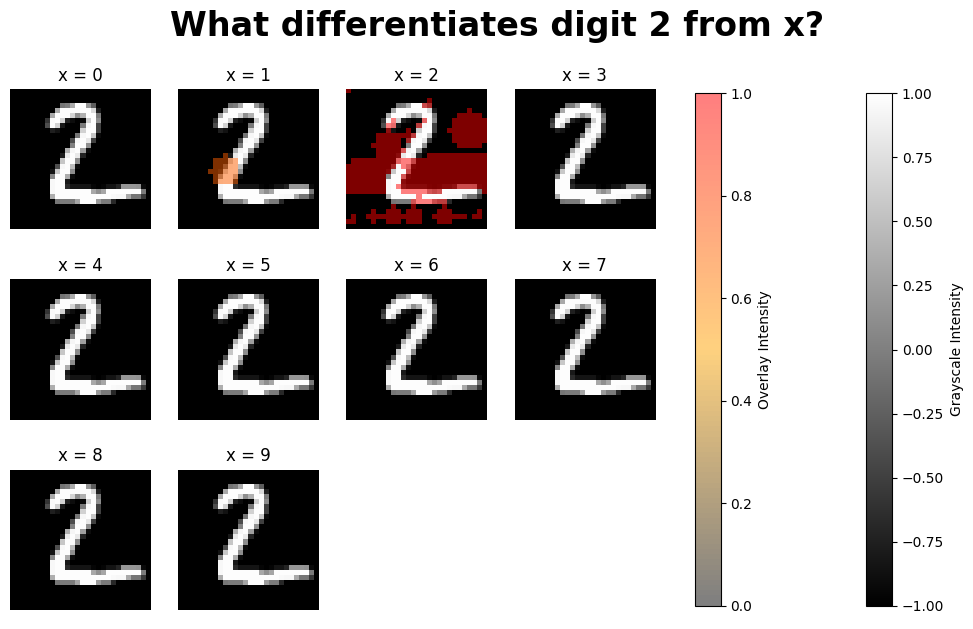

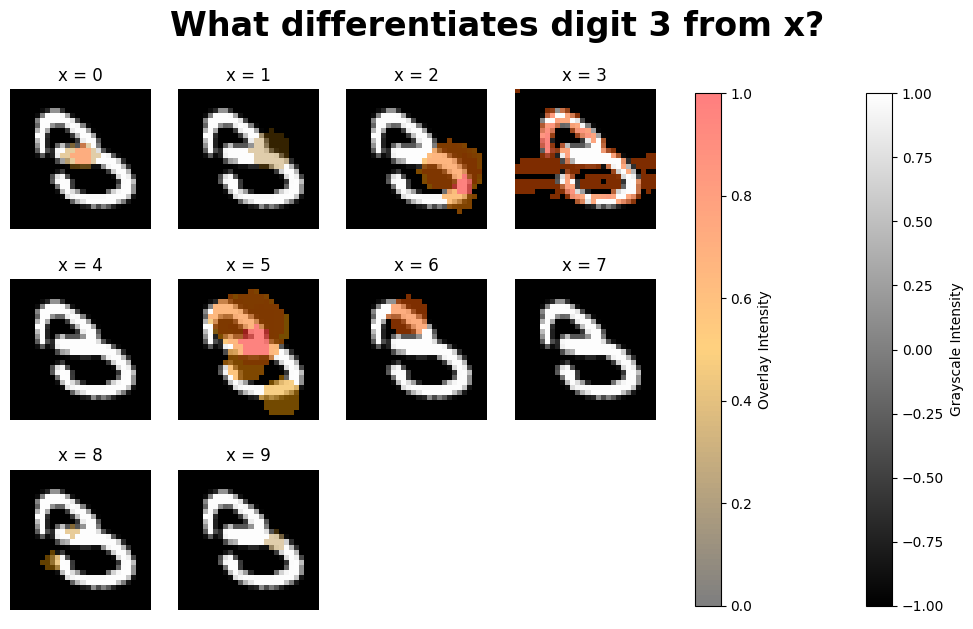

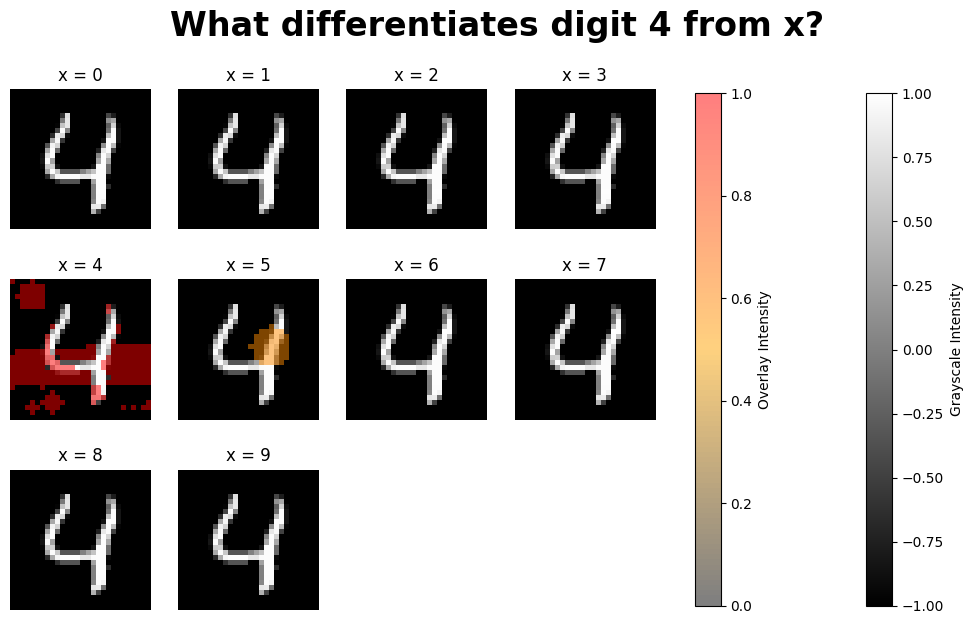

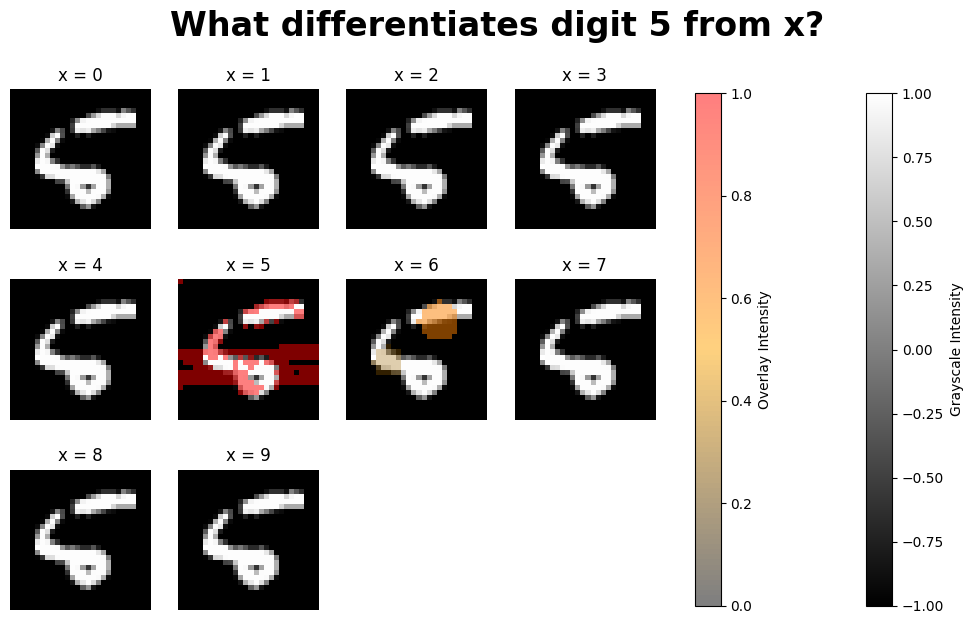

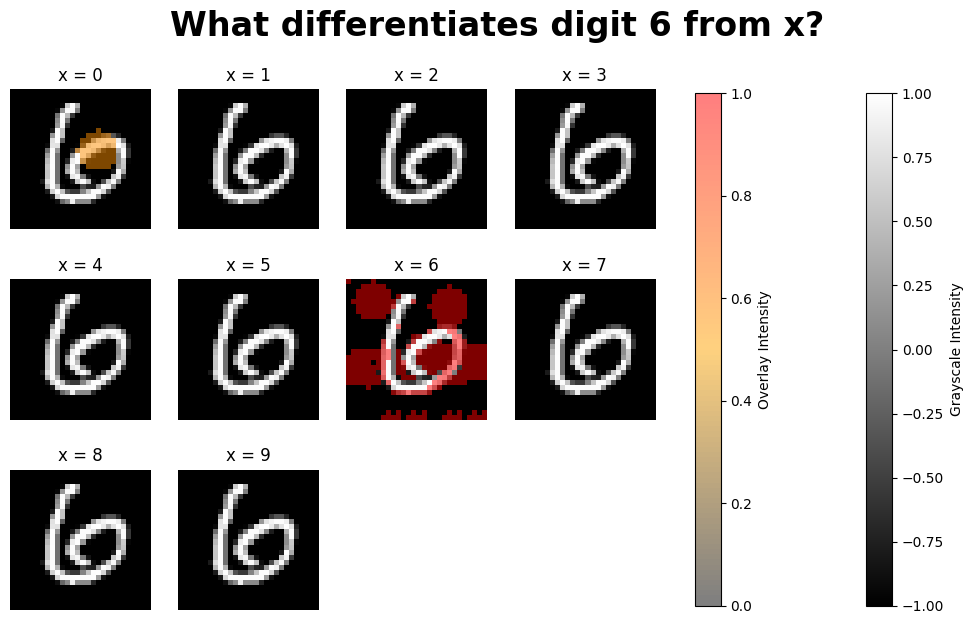

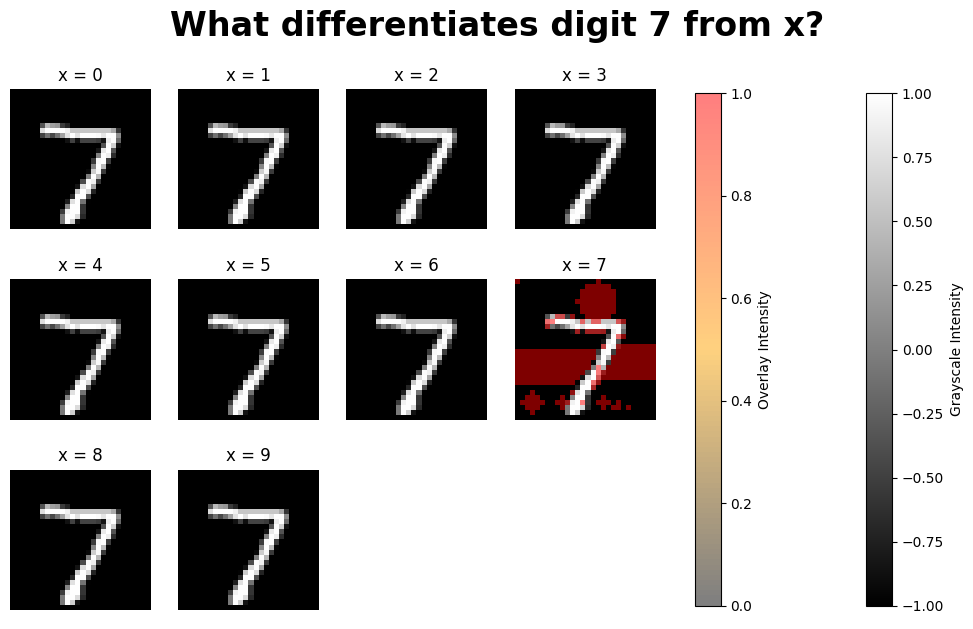

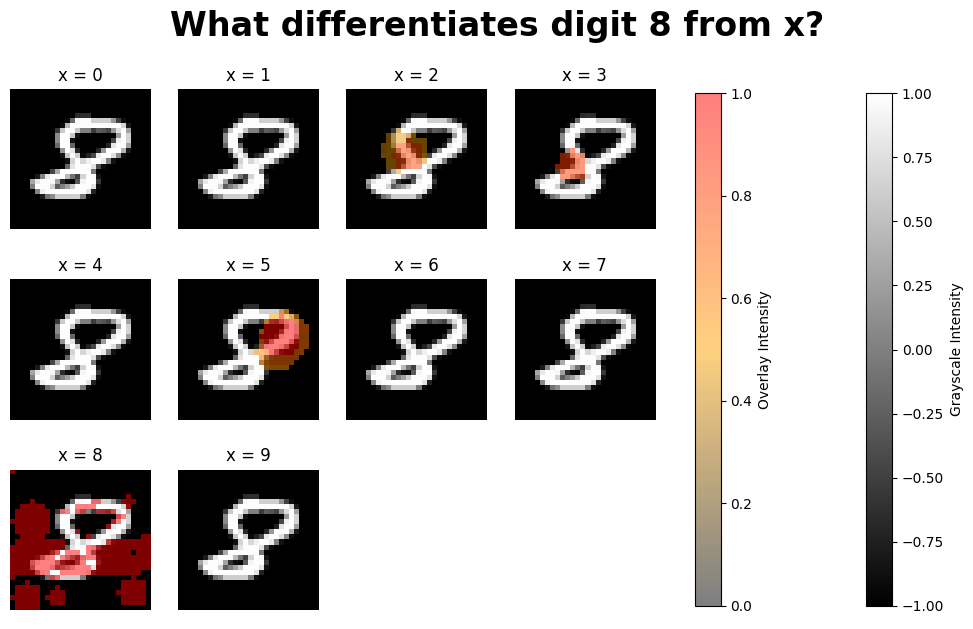

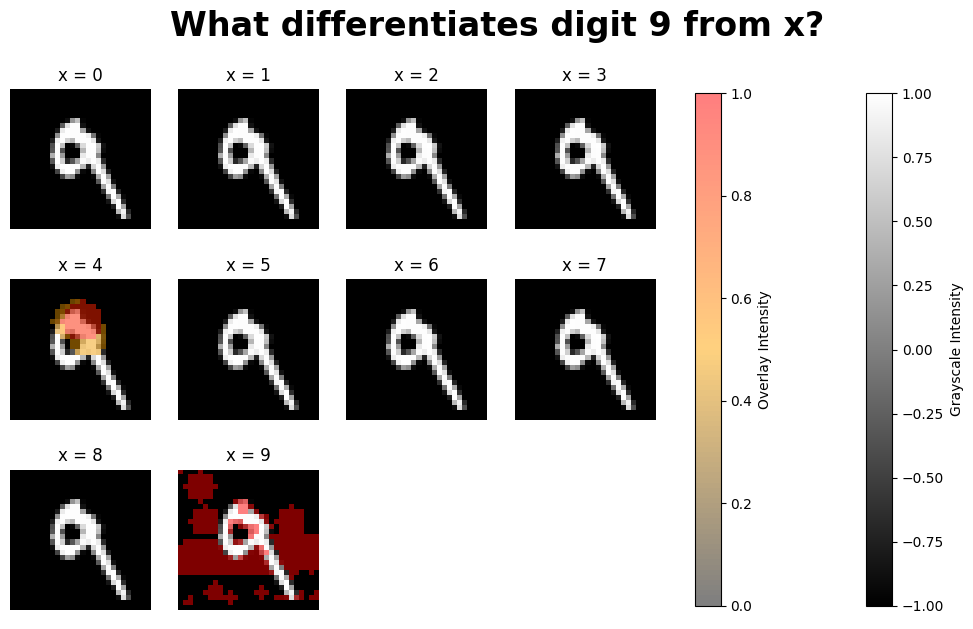

In [14]:
data, labels = next(iter(test_loader))
class_conf = range(10)

for label in range(10):
  # Find the first image corresponding to the current label
  idx = (labels == label).nonzero(as_tuple=True)[0]  # Find indices of all images with the current label

  # Select the first image that matches the current label
  image = data[idx[0]]  # Choose the first image corresponding to the current label

  # Get the importance for this image and label
  importance = scalable_convs(image, range(1, 9), 1)

  all_image_np, all_result_tensor_np = illustrate_prep(importance, class_conf)

  illustrate(all_image_np, all_result_tensor_np, class_conf, label)
  print('\n\n')